In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm

Read data

In [20]:
SET = 4

pseudo = pd.read_csv('finalised pseudodata.csv')
pseudo = pseudo[pseudo['set'] == SET]

data_all = pd.read_parquet(f'./data/sample/set_{SET}.parquet')
history_all = pd.read_parquet(f'./data/history/set_{SET}.parquet')

Model Loss plot

Text(0, 0.5, 'Loss')

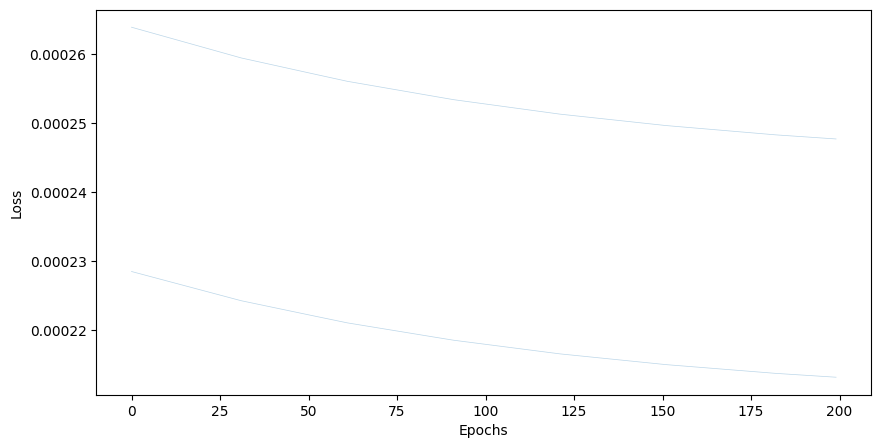

In [21]:
fig, ax = plt.subplots(figsize=(10,5))
for replica, history in history_all.groupby('replica'):
    epoch = np.arange(len(history))
    ax.plot(epoch, history['loss'], c='tab:blue', lw=0.5, alpha=0.3)

ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

Cross Section Plots

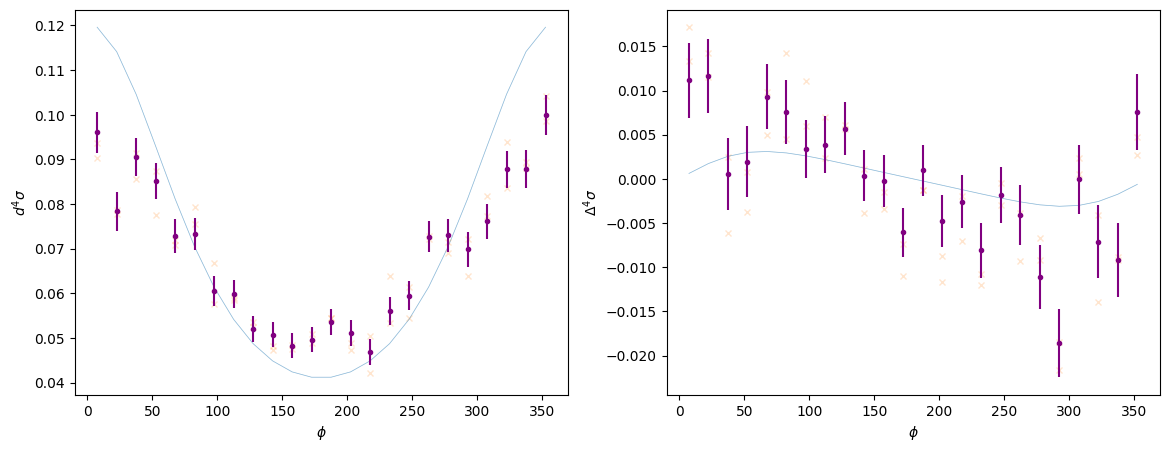

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

for replica, data in data_all.groupby('replica'):
    
    ax[0].plot(data['phi'], data['dsig_fit'], c='tab:blue', lw=0.5, alpha=0.3)
    ax[0].plot(data['phi'], data['dsig_sample'], 'x', c='tab:orange', alpha=0.2, ms=4)

    ax[1].plot(data['phi'], data['delsig_fit'], c='tab:blue', lw=0.5, alpha=0.3)
    ax[1].plot(data['phi'], data['delsig_sample'], 'x', c='tab:orange', alpha=0.2, ms=4)

ax[0].errorbar(pseudo['phi'], pseudo['dsig'], pseudo['dsig_err'], fmt='.', c='purple')
ax[1].errorbar(pseudo['phi'], pseudo['delsig'], pseudo['delsig_err'], fmt='.', c='purple')

ax[0].set_xlabel(r'$\phi$')
ax[0].set_ylabel(r'$d^4\sigma$')

ax[1].set_xlabel(r'$\phi$')
ax[1].set_ylabel(r'$\Delta^4\sigma$');

CFF Plots

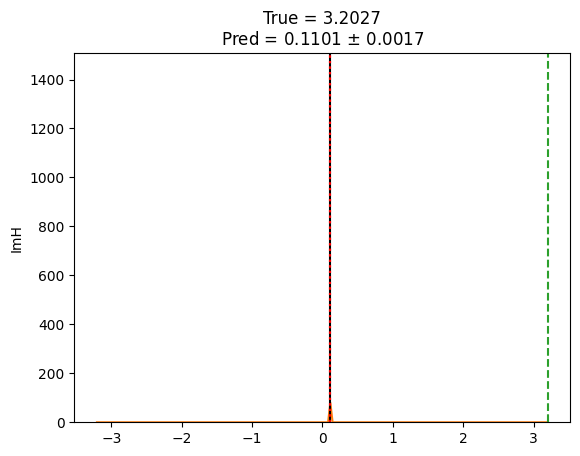

In [24]:
def cffs(name):
    pred = data_all[name+'_pred'].unique()
    
    if len(pred)==1:
        print('Not Evaluated')
        return
    
    true = pseudo[name].unique()[0]
    mu, sigma = norm.fit(pred)
    plt.hist(pred, bins=10, density=True, alpha=0.6)

    x = np.linspace(min(min(pred), -abs(true)), max(max(pred), abs(true)), 200)
    pdf = norm.pdf(x, mu, sigma)
    plt.plot(x, pdf)
    plt.axvline(mu, c='k')
    plt.axvline(mu + sigma, ls=':', c='r')
    plt.axvline(mu - sigma, ls=':', c='r')
    plt.axvline(true, ls='--', c='tab:green')

    plt.title(f'True = {true:.4f}\nPred = {mu:.4f} '+r'$\pm$'+f' {sigma:.4f}')
    plt.ylabel(name) 

cffs('ImH')